## Ubiquant Market Prediction

### 금융데이터
https://www.kaggle.com/competitions/ubiquant-market-prediction
https://www.kaggle.com/code/miingkang/ml-from-the-beginning-to-the-end-for-newbies/notebook?scriptVersionId=91431811

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path = '/content/drive/MyDrive/취준/코딩/kaggle/kaggle_data/'

### data & import

In [8]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from pathlib import Path
import seaborn as sns

https://www.kaggle.com/code/robikscube/fast-data-loading-and-low-mem-with-parquet-files

In [9]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_parquet(path + '/train_low_mem.parquet')

CPU times: user 10.7 s, sys: 11.8 s, total: 22.6 s
Wall time: 35.7 s


In [10]:
start_mem = train.memory_usage().sum() / 1024**2

def decreasing_train(train):
    for col in train.columns:
        col_type = train[col].dtype

        if col_type != object:
            c_min = train[col].min()
            c_max = train[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train[col] = train[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train[col] = train[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train[col] = train[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train[col] = train[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train[col] = train[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train[col] = train[col].astype(np.float32)
                else:
                    train[col] = train[col].astype(np.float64)
        else:
            train[col] = train[col].astype('category')
    return train

train = decreasing_train(train)
end_mem = train.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%


### take a look & split

In [11]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(303)
memory usage: 1.9 GB


None

In [12]:
for i in ['investment_id', 'time_id']:
    print(f'------------------{i} / value counts------------------')
    display(train[i].value_counts())

------------------investment_id / value counts------------------


investment_id
2752.0    3576
3052.0    3528
3304.0    3516
2356.0    3514
2712.0    3510
          ... 
85.0         8
905.0        8
2558.0       8
3662.0       7
1415.0       2
Name: count, Length: 2788, dtype: int64

------------------time_id / value counts------------------


time_id
1214.0    3445
1209.0    3444
1211.0    3440
1207.0    3440
1208.0    3438
          ... 
415.0      659
362.0      651
374.0      600
398.0      539
492.0      512
Name: count, Length: 1211, dtype: int64

In [13]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


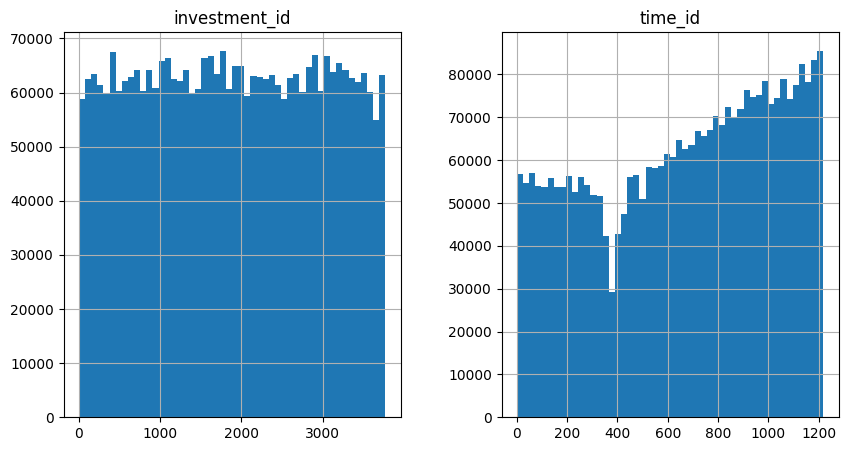

In [14]:
train[['investment_id', 'time_id']].hist(bins=50, figsize=(10,5))
plt.show()
# time_id 380-410 are strange and You can see time_id's increasing aspect

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, train['time_id']):
    train_set = train.loc[train_index]
    test_set = train.loc[test_index]

In [16]:
display(train_set.head())
display(test_set.head())

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
1291499,596_2613,596.0,2612.0,-1.039062,-2.169922,0.451904,0.373779,-0.406006,0.235474,-0.053711,...,0.575195,1.173828,-0.178955,0.122192,0.030930,-0.092041,-0.350342,-0.183716,-1.961914,-0.156982
2284626,952_2249,952.0,2248.0,4.496094,-0.580078,1.900391,-2.388672,2.791016,-0.160034,0.683594,...,-0.257080,-0.481201,1.055664,0.655273,-0.686035,0.336914,0.800781,-1.678711,1.634766,0.521484
2069171,882_985,882.0,985.0,1.631836,-4.792969,0.651367,-0.087219,-0.421387,0.117065,-1.821289,...,0.935547,0.503418,-1.875000,0.028427,-2.619141,-0.204834,-1.999023,-0.768555,-0.278809,0.211792
2283919,952_1403,952.0,1403.0,-0.863281,-0.430908,-0.967773,0.470703,-0.314941,0.200317,-0.495850,...,-0.802246,-0.481201,0.335449,-1.526367,-0.686035,0.191650,0.800781,-0.055420,-0.583984,-0.046295
899233,427_230,427.0,230.0,-0.648438,1.619141,2.716797,-0.097351,-0.069641,0.182861,-0.139038,...,2.382812,1.916016,1.235352,0.326660,-0.667969,0.017624,0.973145,0.294189,0.000000,-0.946289


,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
1691233,749_2816,749.0,2816.0,0.749023,0.176392,0.632812,0.351807,-0.265137,-0.257568,-1.043945,...,0.604004,-0.589844,-0.396240,-1.767578,-0.886230,-0.454834,-0.815430,0.343506,-0.719727,-0.339600
473122,209_3065,209.0,3064.0,1.022461,-0.143311,-0.717773,-0.323975,-0.643555,0.074829,0.025772,...,-1.678711,0.559570,-1.568359,0.078369,-2.404297,0.108032,-0.873535,0.697754,-1.202148,-0.132690
1967268,847_1523,847.0,1523.0,-0.222534,1.001953,-0.792480,0.653809,-0.282959,0.742676,1.367188,...,0.410889,1.502930,-1.359375,-2.919922,2.171875,-0.350830,0.552246,-0.532227,0.946777,0.484375
790312,355_3144,355.0,3144.0,-0.053253,-0.917480,-1.256836,-0.645996,-0.358643,0.280273,-0.013283,...,1.992188,0.562988,-0.569336,1.824219,-2.164062,1.131836,1.369141,-0.855957,0.681152,0.576172
1593756,713_2374,713.0,2374.0,-1.413086,-0.520020,2.046875,1.053711,0.406982,-0.480225,0.000427,...,-1.374023,1.172852,1.583008,0.409180,0.675781,-0.601074,1.221680,2.015625,1.768555,-0.747070


In [17]:
test_x = test_set.drop(['target', 'row_id'], axis=1).copy()
test_target = test_set['target'].copy()

In [18]:
display(test_x.head())
display(test_target.head())

,time_id,investment_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
1691233,749.0,2816.0,0.176392,0.632812,0.351807,-0.265137,-0.257568,-1.043945,-0.491211,0.634277,...,0.604004,-0.589844,-0.396240,-1.767578,-0.886230,-0.454834,-0.815430,0.343506,-0.719727,-0.339600
473122,209.0,3064.0,-0.143311,-0.717773,-0.323975,-0.643555,0.074829,0.025772,0.495850,0.395264,...,-1.678711,0.559570,-1.568359,0.078369,-2.404297,0.108032,-0.873535,0.697754,-1.202148,-0.132690
1967268,847.0,1523.0,1.001953,-0.792480,0.653809,-0.282959,0.742676,1.367188,1.747070,0.198730,...,0.410889,1.502930,-1.359375,-2.919922,2.171875,-0.350830,0.552246,-0.532227,0.946777,0.484375
790312,355.0,3144.0,-0.917480,-1.256836,-0.645996,-0.358643,0.280273,-0.013283,-0.359375,0.408203,...,1.992188,0.562988,-0.569336,1.824219,-2.164062,1.131836,1.369141,-0.855957,0.681152,0.576172
1593756,713.0,2374.0,-0.520020,2.046875,1.053711,0.406982,-0.480225,0.000427,1.741211,0.896484,...,-1.374023,1.172852,1.583008,0.409180,0.675781,-0.601074,1.221680,2.015625,1.768555,-0.747070


1691233    0.749023
473122     1.022461
1967268   -0.222534
790312    -0.053253
1593756   -1.413086
Name: target, dtype: float16

In [19]:
display(train_set['time_id'].value_counts() / len(train_set))
display(test_set['time_id'].value_counts() / len(test_set))

time_id
1214.0    0.001097
1209.0    0.001096
1211.0    0.001095
1207.0    0.001095
1213.0    0.001094
            ...   
415.0     0.000210
362.0     0.000207
374.0     0.000191
398.0     0.000171
492.0     0.000163
Name: count, Length: 1211, dtype: float64

time_id
1209.0    0.001097
1214.0    0.001097
1219.0    0.001095
1211.0    0.001095
1212.0    0.001095
            ...   
415.0     0.000210
362.0     0.000207
374.0     0.000191
398.0     0.000172
492.0     0.000162
Name: count, Length: 1211, dtype: float64

In [20]:
del train
del test_set

### EDA & visualization

In [21]:
ubiquant = train_set.copy()

In [25]:
ubiquant = ubiquant.astype({'time_id': 'int32',
                            'investment_id': 'int32'})
ubiquant.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
1291499,596_2613,596,2612,-1.039062,-2.169922,0.451904,0.373779,-0.406006,0.235474,-0.053711,...,0.575195,1.173828,-0.178955,0.122192,0.030930,-0.092041,-0.350342,-0.183716,-1.961914,-0.156982
2284626,952_2249,952,2248,4.496094,-0.580078,1.900391,-2.388672,2.791016,-0.160034,0.683594,...,-0.257080,-0.481201,1.055664,0.655273,-0.686035,0.336914,0.800781,-1.678711,1.634766,0.521484
2069171,882_985,882,985,1.631836,-4.792969,0.651367,-0.087219,-0.421387,0.117065,-1.821289,...,0.935547,0.503418,-1.875000,0.028427,-2.619141,-0.204834,-1.999023,-0.768555,-0.278809,0.211792
2283919,952_1403,952,1403,-0.863281,-0.430908,-0.967773,0.470703,-0.314941,0.200317,-0.495850,...,-0.802246,-0.481201,0.335449,-1.526367,-0.686035,0.191650,0.800781,-0.055420,-0.583984,-0.046295
899233,427_230,427,230,-0.648438,1.619141,2.716797,-0.097351,-0.069641,0.182861,-0.139038,...,2.382812,1.916016,1.235352,0.326660,-0.667969,0.017624,0.973145,0.294189,0.000000,-0.946289


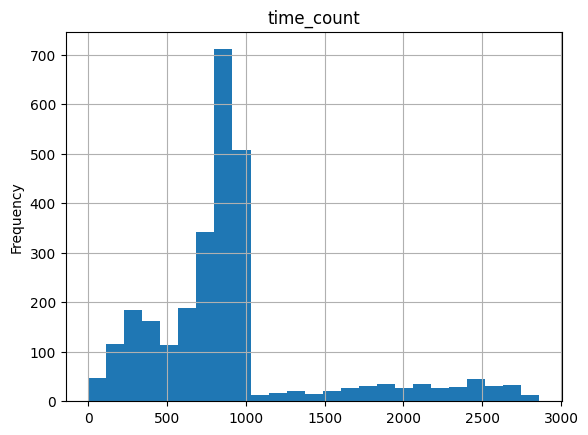

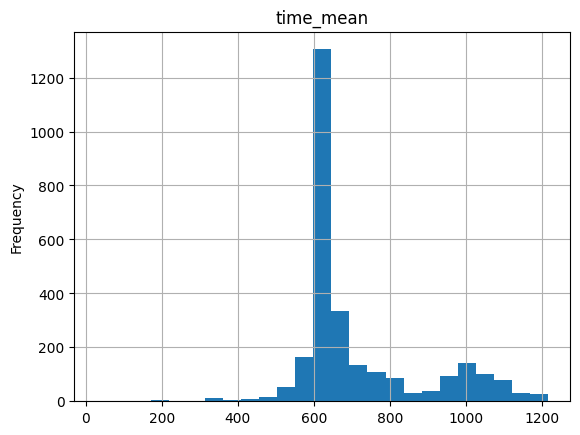

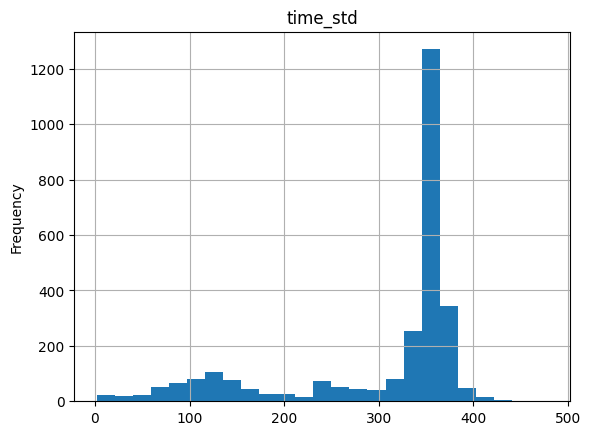

In [26]:
time_count = ubiquant['time_id'].groupby(ubiquant['investment_id']).count()
time_count.plot(kind='hist', bins=25, grid=True, title='time_count')
plt.show()

time_mean = ubiquant['time_id'].groupby(ubiquant['investment_id']).mean()
time_mean.plot(kind='hist', bins=25, grid=True, title='time_mean')
plt.show()

time_std = ubiquant['time_id'].groupby(ubiquant['investment_id']).std()
time_std.plot(kind='hist', bins=25, grid=True, title='time_std')
plt.show()

del time_count
del time_mean
del time_std

In [ ]:
#scatter plot
from pandas.plotting import scatter_matrix

attri = ['investment_id', 'time_id', 'f_0', 'f_1']
scatter_matrix(ubiquant[attri], figsize = (12,8))

In [ ]:
#check outlier
investment_count = ubiquant.groupby(['investment_id'])['target'].count()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
investment_count.plot.hist(bins=60, color = 'blue', alpha = 0.4)
plt.title("Count of investment by target")
plt.show()

investment_mean = ubiquant.groupby(['investment_id'])['target'].mean()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
investment_mean.plot.hist(bins=60, color = 'blue', alpha = 0.4)
plt.title("Mean of investment by target")
plt.show()

ax = sns.jointplot(x=investment_count, y=investment_mean, kind='reg',
                  height=8, color = 'blue')
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('mean target')
plt.show()

### feature engineering

In [ ]:
# make label
train_x = train_set.drop(['target', 'row_id'], axis=1).copy()
train_target = train_set['target'].copy()
display(train_x.head())
train_target.head()

In [ ]:
# Step 2.
outlier_id = investment_mean.reset_index(name='mean')
outlier_id = outlier_id[abs(outlier_id['mean']) < 0.15]
outlier_id = outlier_id['investment_id'].tolist()

# removeing outlier_id
remove_df = train_set[train_set['investment_id'].isin(outlier_id)].copy()
remove_df

In [ ]:
# Step 3.
investment_count = remove_df.groupby(['investment_id'])['target'].count()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
investment_count.plot.hist(bins=60, color = 'blue', alpha = 0.4)
plt.title("Count of investment by target")
plt.show()

investment_mean = remove_df.groupby(['investment_id'])['target'].mean()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
investment_mean.plot.hist(bins=60, color = 'blue', alpha = 0.4)
plt.title("Mean of investment by target")
plt.show()

ax = sns.jointplot(x=investment_count, y=investment_mean, kind='reg',
                  height=8, color = 'blue')
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('mean target')
plt.show()

In [2]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# f_num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])

# ubi_f_pipe = f_num_pipeline.fit_transform(train_set[features])

In [ ]:
del train_set

### modeling & training

In [ ]:
import lightgbm
import xgboost

train_ds = lightgbm.Dataset(train_x, label = train_target)
val_ds = lightgbm.Dataset(test_x, label = test_target)
params = {'learning_rate': 0.01,
          'max_depth': 5,
          'objective': 'regression',
          'metric': 'mse',
          'is_training_metric': True,
          'num_leaves': 144}
model = lightgbm.train(params, train_ds, 85, val_ds)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

prediction = model.predict(test_x)
mse = mean_squared_error(test_target, prediction)
print(f'model mse is {mse}')

In [ ]:
%%time
from sklearn.model_selection import KFold
params = {'learning_rate': 0.01,
          'max_depth': 5,
          'objective': 'regression',
          'metric': 'mse',
          'is_training_metric': True,
          'num_leaves': 144}
kfold = KFold(n_splits=5)
models = []
print('start')

for  train_indices, valid_indices in kfold.split(train_x):
    print('start')
    train_x, val_x = train_x.iloc[train_indices], train_x.iloc[valid_indices]
    train_y, val_y = train_target.iloc[train_indices], train_target.iloc[valid_indices]
    train_ds = lightgbm.Dataset(train_x, label = train_y)
    val_ds = lightgbm.Dataset(val_x, label = val_y)
    print('middle')
    #checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    model = lightgbm.train(params, train_ds, 100, val_ds)
    models.append(model)
    print('finishs')
    pearson_score = stats.pearsonr(model.predict(val_x).ravel(), val_y.values)[0]
    print('Pearson:', pearson_score)
    del train_x
    del val_x
    del train_y
    del val_y
    del train_ds
    del val_ds
    gc.collect()
    break

### tunning

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from lightgbm import LGBMRegressor
# LGB = LGBMRegressor()

# lgb_param_grid = {
#     'num_leaves' : [1,5,10],
#     'learning_rate': [1,0.1,0.01,0.001],
#     'n_estimators': [50, 100, 200, 500, 1000,5000],
#     'max_depth': [15,20,25],
#     'num_leaves': [50, 100, 200],
#     'min_split_gain': [0.3, 0.4],
# }
# gsLGB = GridSearchCV(LGB,param_grid = lgb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
# gsLGB.fit(train_x, train_target)
# LGB_best = gsLGB.best_estimator_

# print('최적 하이퍼 파라미터: ', gsLGB.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(gsLGB.best_score_))

### submission

In [ ]:
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    time_df = test_df.row_id.str.split('_').str[0].astype(int)
    test_df.drop(['row_id'], axis=1, inplace=True)
    test_df['time_id'] = time_df
    sample_prediction_df['target'] = inference(models, test_df)
    env.predict(sample_prediction_df)

## ㅇㄴㅇㄴ